In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import autograd.numpy as np

In [4]:
import tools

In [5]:
(X_train, y_train, X_test, y_test) = tools.get_dataset('mnist-2k')

In [6]:
emb = np.random.random((X_train.shape[0], 2))

In [7]:
import scipy.spatial as ss

In [10]:
EPSILON = np.finfo(np.float64).eps

pdist = ss.distance.pdist(X_train, 'euclidean')
hd_ij = ss.distance.squareform(pdist)

inv_hd_ij_2 = 1./(hd_ij**2 + EPSILON)

In [11]:
def stress(X):
    X = X[:, None, :]
    ld_ij_2 = np.linalg.norm((X - X.swapaxes(0,1)), axis=2)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

In [12]:
def stress_ref(X):
    pdist = ss.distance.pdist(X)
    ld_ij_2 = ss.distance.squareform(pdist)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

In [13]:
def stress_man(X):
    X = X[:, None, :]
    ld_ij_2 = np.sqrt(np.sum(((X - X.swapaxes(0,1))**2), axis=2) + EPSILON)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

In [14]:
stress_ref(emb)

3156107.686649595

In [15]:
stress(emb)

3156107.686649595

In [16]:
stress_man(emb)

3157904.686649595

In [17]:
from autograd import grad

In [18]:
grad_stress = grad(stress_man)

In [19]:
%timeit grad_stress(emb)

698 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# SCIPY optimise

In [20]:
def stress_1D(X):
    X = X.reshape(-1,2)
    X = X[:, None, :]
    ld_ij_2 = np.sqrt(np.sum(((X - X.swapaxes(0,1))**2), axis=2) + EPSILON)
    res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
    return res

In [21]:
grad_stress_1D = grad(stress_1D)

In [22]:
fun = lambda x: grad_stress_1D(x) / 4

In [25]:
from scipy.optimize import minimize

In [26]:
x0 = emb.ravel()

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_train)
from sklearn import preprocessing
pca = preprocessing.scale(pca)

x0 =pca.ravel()

In [43]:
%time res = minimize(stress_1D, x0, method='BFGS', jac=grad_stress_1D, options={'disp': True, 'maxiter': 100})

         Current function value: 408390.170815
         Iterations: 100
         Function evaluations: 105
         Gradient evaluations: 105
CPU times: user 18min 27s, sys: 1min 17s, total: 19min 44s
Wall time: 5min 2s


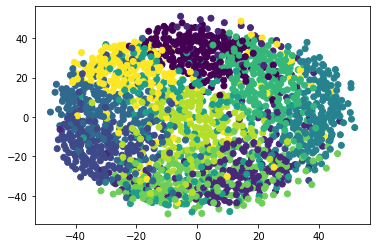

In [44]:
emb_opt = res['x'].reshape(-1,2)
plt.scatter(emb_opt[:,0], emb_opt[:,1], c=y_train)

# using class

In [72]:
class ForceEmbeddingAutoGrad:

    def __init__(self, embedding, pdist):

        self.X = embedding.copy()
        self.hd_ij = pdist
        self.inv_hd_ij_2 = 1./(pdist**2 + EPSILON)
        self.error = []

    def optimize(self, n_iter=100):

#         if (method == 'gd'):
#             optimizer = gd

#         elif method == 'sgd':
        optimizer = sgd

#         else:
#             raise ValueError("Method not supported. Choice are gradient_descent or sgd.")

        def stress_local(X):
            X = X[:, None, :]
            ld_ij_2 = np.sqrt(np.sum(((X - X.swapaxes(0,1))**2), axis=2) + EPSILON)
            res = np.sum((ld_ij_2 - hd_ij)**2 * inv_hd_ij_2)
            return res

        gradient = grad(stress_local)

        cb = lambda: self.error.append(stress(self.X))
        cb()

        for i in range(n_iter):

            g = gradient(self.X)
            cb()

            self.X -= g/2
        # optimizer(gradient, self, callback=cb, num_iters=n_iter)

        return self.X

# https://github.com/HIPS/autograd/blob/6e5ec96993bd7136c8d96cc6bfb11dccd04490aa/autograd/misc/optimizers.py#L33
def sgd(grad, x, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    """Stochastic gradient descent with momentum."""
    velocity = np.zeros(x.shape)
    for i in range(num_iters):
        g = grad()
        if callback: callback(x, i, g)
        velocity = mass * velocity - (1.0 - mass) * g
        # modify x in place: https://stackoverflow.com/questions/12905338/
        x += step_size * velocity

    return x


In [73]:
init = np.random.random((X_train.shape[0], 2))

In [74]:
feag = ForceEmbeddingAutoGrad(init, hd_ij)

In [75]:
feag.optimize(10)

array([[ -6.55241344, -10.02838795],
       [ 25.59098553, -10.20611916],
       [ 18.82287636, -32.15894226],
       ...,
       [ 22.63698986,  20.16138277],
       [ -7.15024635, -26.5763872 ],
       [-24.64921139,  17.75889206]])

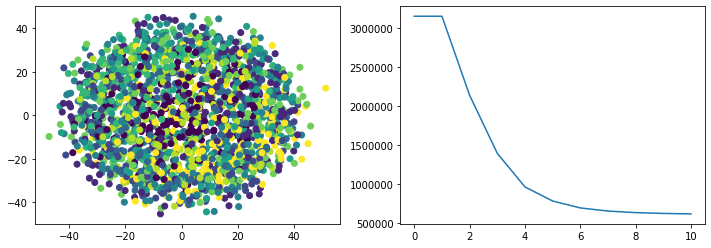

In [76]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].scatter(feag.X[:,0], feag.X[:,1], c=y_train)
ax[1].plot(np.array(feag.error))
# _=ax[1].set_title("{:.2E}".format(fe_pca.stress()))